# Libraries

In [25]:
# Libraries
from simtool import findInstalledSimToolNotebooks, searchForSimTool
from simtool import getSimToolInputs, getSimToolOutputs, Run
#meltheas -> tldr; seperate jupyter notebook with existing code
MeltHEA = searchForSimTool('meltheas')

import json
import pandas as pd
import re
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, HBox
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE, MDS, LocallyLinearEmbedding, Isomap, SpectralEmbedding
from sklearn.linear_model import LinearRegression
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import nanohubremote as nr
from scipy.stats import norm

from lolopy.learners import RandomForestRegressor
from lolopy.metrics import root_mean_squared_error
from lolopy.metrics import standard_error

# Querying Data

In [46]:
# CREDENTIALS

auth_data = { 'grant_type' : 'tool' }
with open(os.environ["SESSIONDIR"]+"/resources") as file:
    lines = [line.split(" ", 1) for line in file.readlines()]
    properties = {line[0].strip(): line[1].strip() for line in lines if len(line)==2}
    auth_data["sessiontoken"] = properties["session_token"]
    auth_data["sessionnum"] = properties["sessionid"]
    
session = nr.Tools(auth_data)

tool = 'meltheas' 

# QUERY FOR INPUTS AND OUTPUTS

req_json = session.requestPost('results/dbexplorer/tool_detail?simtool=true', data={'tool': tool})
req_json = req_json.json()
parameters = req_json['results']

inputs = list(parameters[0][tool]['input'].keys())
#print(inputs)

outputs = list(parameters[0][tool]['output'].keys())
#print(outputs)

# QUERY EVERYTHING FROM THE DATABASE

search = {
    'tool':tool,
    'filters':json.dumps([
        {'field':'input.Tsolid','operation':'>=','value':'2'},     # Filters included to query [Everything] in the cached database
        {'field':'input.composition1','operation':'<=','value':'0.5'},
        {'field':'input.composition2','operation':'<=','value':'0.5'},
        {'field':'input.composition3','operation':'<=','value':'0.5'},
        {'field':'input.composition4','operation':'<=','value':'0.5'},
        {'field':'input.composition5','operation':'<=','value':'0.5'},        
    ]),
    'results':json.dumps(['input.composition1','input.composition2','input.composition3','input.composition4','input.composition5',
                          'input.Tsolid', 'input.Tliquid',
                          'output.Coexistence', 'output.Converged', 'output.melting_temperature',
                          'output.melting_temperature_ci', 'output.fraction_solid', 'output.fraction_liquid', 'output.counts_array',]),    # Selected Parameters (Inputs/Outputs) that will be requested from the query
    'limit':0,    
    'revision':0,
 }

req_json = session.requestPost('results/dbexplorer/search?simtool=true', data=search, timeout=30)
results = req_json.json()

complete_dataframe = pd.DataFrame(results['results']).dropna()
complete_dataframe = complete_dataframe.reset_index(drop=True)
complete_dataframe_copy = complete_dataframe.copy()

#print(complete_dataframe.shape) # (6667, 17) --> All revisions, all time
#display(complete_dataframe)

# Data Preprocessing

In [27]:
columns = {'input.composition1': 'Cr', 'input.composition2': 'Co', 'input.composition3': 'Cu', 'input.composition4': 'Fe', 'input.composition5': 'Ni'}
complete_dataframe.rename(columns = columns, inplace = True)
complete_dataframe = complete_dataframe.loc[(complete_dataframe['output.Coexistence'] == 1) & (complete_dataframe['output.Converged'] == 1)]
complete_dataframe = complete_dataframe.drop_duplicates(subset=['Cr', 'Co', 'Cu', 'Fe', 'Ni'])

df = pd.read_csv('cleaned_list.txt', sep=' ', header=None)
df[8] = [x.replace("_", "/") for x in df[8]]
#display(df)
runs_file = complete_dataframe.copy()

In [28]:
comparison = runs_file[runs_file['squid'].isin(df[8])]
df = df.rename({8 : 'squid'}, axis = 1)
merged_df = pd.merge(comparison, df[[5, 6, 7, 'squid']], left_on='squid', right_on='squid', how='left')

# Drop the 'squid' column from the merged DataFrame as it's no longer needed
merged_df.drop('squid', axis=1, inplace=True)
merged_df.drop('date', axis=1, inplace=True)

# Rename the columns 5, 6, 7, to month, day, year
merged_df.rename(columns={5: 'Month', 6: 'Day', 7: 'Year'}, inplace=True)

#Drop duplicates
merged_df = merged_df.drop_duplicates(subset=['Cr', 'Co', 'Cu', 'Fe', 'Ni'])

In [29]:
def filter_dates(df, month, day, year):
    target_date = datetime(year, month, day)
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    filtered_df = df[df['Date'] <= target_date]
    return filtered_df
def convert_abbr_to_num(df, column_name):
    month_mapping = {'Jan':  1, 'Feb':  2, 'Mar':  3, 'Apr':  4, 'May':  5, 'Jun':  6,
                     'Jul':  7, 'Aug':  8, 'Sep':  9, 'Oct':  10, 'Nov':  11, 'Dec':  12}
    df[column_name] = df[column_name].apply(lambda x: month_mapping.get(x, x))
    
    return df

In [30]:
prior_to_2022_data = convert_abbr_to_num(merged_df, 'Month')
prior_to_2022_data = filter_dates(prior_to_2022_data, 1, 1, 2022)
prior_to_2022_data = prior_to_2022_data.reset_index()

In [31]:
columns = ['Cr', 'Co', 'Cu', 'Fe', 'Ni', 'input.Tsolid', 'input.Tliquid', 'output.melting_temperature']
known = prior_to_2022_data[columns].copy()

In [32]:
known

,Cr,Co,Cu,Fe,Ni,input.Tsolid,input.Tliquid,output.melting_temperature
0,0.10,0.0,0.0,0.50,0.40,1591.437851,3182.875703,2460.416126
1,0.20,0.0,0.4,0.20,0.20,1207.103589,2414.207177,1846.231777
2,0.10,0.4,0.0,0.40,0.10,1517.457703,3034.915406,2389.329413
3,0.20,0.2,0.4,0.10,0.10,1208.618834,2417.237668,1798.395653
4,0.33,0.0,0.0,0.33,0.34,1428.412500,2856.825000,2295.532645
...,...,...,...,...,...,...,...,...
264,0.30,0.4,0.1,0.20,0.00,1361.212076,2722.424153,2115.888798
265,0.30,0.4,0.1,0.00,0.20,1336.748640,2673.497280,1981.905057
266,0.30,0.4,0.0,0.10,0.20,1445.883480,2891.766961,2140.598680
267,0.30,0.4,0.0,0.00,0.30,1408.610080,2817.220160,2102.176084


In [33]:
# Extract the relevant columns
melting_temp = known['output.melting_temperature'].values.reshape(-1, 1)
tsolid = known['input.Tsolid'].values.reshape(-1, 1)
tliquid = known['input.Tliquid'].values.reshape(-1, 1)

# Compute the linear regression parameters for input.Tsolid vs. output.melting_temperature
model_tsolid = LinearRegression()
model_tsolid.fit(melting_temp, tsolid)
tsol_slope = model_tsolid.coef_[0][0]
tsol_intercept = model_tsolid.intercept_[0]

# Compute the linear regression parameters for input.Tliquid vs. output.melting_temperature
model_tliquid = LinearRegression()
model_tliquid.fit(melting_temp, tliquid)
tliq_slope = model_tliquid.coef_[0][0]
tliq_intercept = model_tliquid.intercept_[0]

# Print the results
print("Tsolid slope:", tsol_slope)
print("Tsolid intercept:", tsol_intercept)
print("Tliquid slope:", tliq_slope)
print("Tliquid intercept:", tliq_intercept)


Tsolid slope: 0.6020591471024813
Tsolid intercept: 98.95717686182002
Tliquid slope: 1.204118294204953
Tliquid intercept: 197.9143537236514


In [34]:
known.drop(columns = {'input.Tsolid', 'input.Tliquid'}, axis = 1, inplace = True)

In [35]:
from itertools import product

# Create positions with 0.1 step size
nx = 11
x1 = np.linspace(0, 1, nx)

# Generate combinations directly using itertools
combinations = product(x1, repeat=5)

# Convert to DataFrame and filter
columns = ['Cr', 'Co', 'Cu', 'Fe', 'Ni']
plausible_compositions = pd.DataFrame(combinations, columns=columns)

# Check if the sum is exactly equal to 1
plausible_compositions['sum'] = plausible_compositions.sum(axis=1)
plausible_compositions = plausible_compositions[plausible_compositions['sum'].eq(1)]

# Filter values <= 0.5
for col in columns:
    plausible_compositions = plausible_compositions[plausible_compositions[col] <= 0.5]

# Round values to 0.1
plausible_compositions = plausible_compositions.round(1)

# Drop the 'sum' column
plausible_compositions = plausible_compositions.drop('sum', axis=1)

# Show the DataFrame
unknown = plausible_compositions
unknown.reset_index(inplace=True)
unknown.drop('index', axis = 1, inplace = True)

In [36]:
df1 = unknown.copy()
df2 = known.copy()
df1.round(1)
df2.round(2)

,Cr,Co,Cu,Fe,Ni,output.melting_temperature
0,0.10,0.0,0.0,0.50,0.40,2460.42
1,0.20,0.0,0.4,0.20,0.20,1846.23
2,0.10,0.4,0.0,0.40,0.10,2389.33
3,0.20,0.2,0.4,0.10,0.10,1798.40
4,0.33,0.0,0.0,0.33,0.34,2295.53
...,...,...,...,...,...,...
264,0.30,0.4,0.1,0.20,0.00,2115.89
265,0.30,0.4,0.1,0.00,0.20,1981.91
266,0.30,0.4,0.0,0.10,0.20,2140.60
267,0.30,0.4,0.0,0.00,0.30,2102.18


In [37]:
# Merge df1 and df2 on the first 5 columns
merged_df = pd.merge(df1, df2, on=['Cr', 'Co', 'Cu', 'Fe', 'Ni'], how='left', indicator=True)

# Keep only the rows from df1 that don't have duplicates in the merged dataframe
filtered_df1 = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

unknown = filtered_df1
unknown.drop('output.melting_temperature', axis = 1, inplace = True)

In [38]:
sample = ['Cr', 'Co', 'Cu', 'Fe', 'Ni']

In [39]:
#Rule of Mixtures Calculation

data = {
  "Cr": [2.790000e+02, 1.400000e+00, 1.270000e-07, 4.900000e-06, 1.120000e+03, 2.944000e+03, 5.199610e+01, 2.100000e-01, 7.140000e+03, 1.660000e+00, 2.180000e+03],
  "Co": [2.090000e+02, 1.350000e+00, 6.000000e-08, 1.300000e-05, 7.000000e+02, 3.200000e+03, 5.893319e+01, 3.100000e-01, 8.900000e+03, 1.880000e+00, 1.768000e+03],
  "Cu": [1.300000e+02, 1.350000e+00, 1.720000e-08, 1.650000e-05, 8.740000e+02, 3.200000e+03, 6.354600e+01, 3.400000e-01, 8.920000e+03, 1.900000e+00, 1.357770e+03],
  "Fe": [2.110000e+02, 1.400000e+00, 1.000000e-07, 1.180000e-05, 4.900000e+02, 3.134000e+03, 5.584500e+01, 2.900000e-01, 7.874000e+03, 1.830000e+00, 1.811000e+03],
  "Ni": [2.000000e+02, 1.350000e+00, 7.200000e-08, 1.340000e-05, 7.000000e+02, 3.186000e+03, 5.869340e+01, 3.100000e-01, 8.908000e+03, 1.910000e+00, 1.728000e+03]
}

index = ['youngs_modulus', 'atomic_radius', 'electrical_resistivity', 'CTE', 'hardness', 'boiling_point', 'atomic_mass', 'poissons_ratio', 'density_of_solid', 'en_gosh', 'melting_point']

c_df = pd.DataFrame(data, index=index)

actual_qued_values = ['youngs_modulus', 'atomic_radius', 'electrical_resistivity','CTE','hardness','boiling_point',
                         'atomic_mass','poissons_ratio','density_of_solid','en_gosh','melting_point']


#Apply Rule of Mixtures
def rule_mixtures(df2,df,sample): 
    #Creats column of first rule mixture descriptors to concatenate to
    cr = 0
    for comps in sample:
        cr = cr+df2[comps]*df[comps][0]
    cr = cr.to_frame()

    #Concatenate rest of compositions with rule of mixtures applied
    for x in range(1,len(actual_qued_values)):
        cf = 0
        for comps in sample:
            cf = cf + df2[comps]*df[comps][x]
        cf.to_frame()
        cr = pd.concat([cr,cf], axis=1)

    #Renames columns to descriptors
    cr.columns = actual_qued_values
    return cr

In [40]:
uk = rule_mixtures(unknown, c_df, sample)
unknown = pd.concat([unknown, uk], axis=1)

kn = rule_mixtures(known, c_df, sample)
known = pd.concat([known, kn], axis=1)

In [41]:
column_to_move = known.pop('output.melting_temperature')
known['output.melting_temperature'] = column_to_move
unknown['Predicted Melting Temp'] = 0
unknown.reset_index(inplace = True, drop = True)

In [42]:
known

,Cr,Co,Cu,Fe,Ni,youngs_modulus,atomic_radius,electrical_resistivity,CTE,hardness,boiling_point,atomic_mass,poissons_ratio,density_of_solid,en_gosh,melting_point,output.melting_temperature
0,0.10,0.0,0.0,0.50,0.40,213.4,1.380,9.150000e-08,0.000012,637.0,3135.80,56.599470,0.2900,8214.20,1.8450,1814.700,2460.416126
1,0.20,0.0,0.4,0.20,0.20,190.0,1.370,6.668000e-08,0.000013,811.6,3132.80,58.725300,0.2980,8352.40,1.8400,1686.908,1846.231777
2,0.10,0.4,0.0,0.40,0.10,215.9,1.375,8.390000e-08,0.000012,658.0,3146.60,56.980226,0.2920,8314.40,1.8410,1822.400,2389.329413
3,0.20,0.2,0.4,0.10,0.10,190.7,1.365,6.148000e-08,0.000013,832.6,3140.80,59.058098,0.3000,8454.20,1.8420,1686.608,1798.395653
4,0.33,0.0,0.0,0.33,0.34,229.7,1.383,9.939000e-08,0.000010,769.3,3088.98,55.543319,0.2704,7983.34,1.8011,1904.550,2295.532645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.30,0.4,0.1,0.20,0.00,222.5,1.375,8.382000e-08,0.000011,801.4,3110.00,56.695706,0.2790,8168.80,1.8060,1859.177,2115.888798
265,0.30,0.4,0.1,0.00,0.20,220.3,1.365,7.822000e-08,0.000011,843.4,3120.40,57.265386,0.2830,8375.60,1.8220,1842.577,1981.905057
266,0.30,0.4,0.0,0.10,0.20,228.4,1.370,8.650000e-08,0.000011,805.0,3113.80,56.495286,0.2780,8271.00,1.8150,1887.900,2140.598680
267,0.30,0.4,0.0,0.00,0.30,227.3,1.365,8.370000e-08,0.000011,826.0,3119.00,56.780126,0.2800,8374.40,1.8230,1879.600,2102.176084


In [43]:
unknown

,Cr,Co,Cu,Fe,Ni,youngs_modulus,atomic_radius,electrical_resistivity,CTE,hardness,boiling_point,atomic_mass,poissons_ratio,density_of_solid,en_gosh,melting_point,Predicted Melting Temp
0,0.0,0.1,0.2,0.2,0.5,189.1,1.360,6.544000e-08,0.000014,692.8,3179.8,59.118219,0.312,8702.8,1.889,1674.554,0
1,0.0,0.1,0.2,0.3,0.4,190.2,1.365,6.824000e-08,0.000013,671.8,3174.6,58.833379,0.310,8599.4,1.881,1682.854,0
2,0.0,0.1,0.3,0.1,0.5,181.0,1.355,5.716000e-08,0.000014,731.2,3186.4,59.888319,0.317,8807.4,1.896,1629.231,0
3,0.0,0.1,0.3,0.2,0.4,182.1,1.360,5.996000e-08,0.000014,710.2,3181.2,59.603479,0.315,8704.0,1.888,1637.531,0
4,0.0,0.1,0.3,0.4,0.2,184.3,1.370,6.556000e-08,0.000014,668.2,3170.8,59.033799,0.311,8497.2,1.872,1654.131,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.5,0.3,0.0,0.1,0.1,243.3,1.380,9.870000e-08,0.000009,889.0,3064.0,55.131847,0.258,7918.2,1.768,1974.300,0
321,0.5,0.3,0.0,0.2,0.0,244.4,1.385,1.015000e-07,0.000009,868.0,3058.8,54.847007,0.256,7814.8,1.760,1982.600,0
322,0.5,0.3,0.1,0.0,0.1,235.2,1.375,9.042000e-08,0.000009,927.4,3070.6,55.901947,0.263,8022.8,1.775,1928.977,0
323,0.5,0.3,0.1,0.1,0.0,236.3,1.380,9.322000e-08,0.000009,906.4,3065.4,55.617107,0.261,7919.4,1.767,1937.277,0


# Active Learning

In [ ]:
def piecewise(m_row, s_row):
    outputs = []
    for m, s in zip(m_row, s_row):
        if s > 0:
            output = s * norm.pdf(m / s) + m * norm.cdf(m / s)
        else:
            output = max(np.max(m), 0)
        outputs.append(output)
    return outputs

In [ ]:
not_known = unknown.copy()
counter = 0

In [ ]:
inputs = getSimToolInputs(MeltHEA) # we can get a list of inputs

In [ ]:
list_df = pd.DataFrame(columns = ['exp', 'Cr', 'Co', 'Cu', 'Fe', 'Ni', 'melting_temp', 'ci', 'count'])

In [56]:
#Set inputs
n_steps = 15 # number of expirements
time_per_simmul = 100 #Time per simulation
box_len = 18 #box length
iaf = "MM" #select acquisition function (MM,UCB,MLI,MEI,MU,Random)
not_known = unknown.copy()

patience_counter = 0

#SPECIFY K FOR UCB
k = 1

known_min = 0

counter_list = []

In [ ]:
for i in range(n_steps):

    print("-------------------------------------------------------------")
    print("Experiment # ", i)
    
    #Random Forest shit
    
    X_train = known.iloc[:, :16].values # Features
    y_train = known.iloc[:, -1].values    # Target

    # Train the Random Forest Model using lolopy
    rf = RandomForestRegressor(num_trees = 350)
    rf.fit(X_train, y_train)

    # Prepare the unknown data
    X_unknown = not_known.iloc[:, :16] # Features from unknown DataFrame

    # Predict on the unknown data and get the standard deviation of the predictions
    y_pred, y_std = rf.predict(X_unknown, return_std=True)

    # Convert the predictions and standard deviations to Numpy arrays
    predictions_np = np.array(y_pred).reshape(-1, 1)
    std_dev_array = np.array(y_std).reshape(-1, 1)



    # Append the predictions as a new column to the DataFrame
    not_known['Predicted Melting Temp'] = predictions_np
    
    not_known.reset_index(inplace = True, drop = True)

    
    # EARLY STOPPING / ACQUISITION - need to add rest of the acquisition functions back later
    
    if iaf == "MM":
        min_prediction_index = not_known['Predicted Melting Temp'].idxmin()
        prediction_row = not_known.iloc[min_prediction_index, :]
        prediction_row = pd.DataFrame(prediction_row).transpose()
        
        print("Min Prediction Row Selected", prediction_row)
        
        not_known = not_known.drop(min_prediction_index)
        not_known = not_known.reset_index(drop = True)
        
        min_prediction_value = prediction_row['Predicted Melting Temp'].item()
        print('Min Prediction Value', min_prediction_value)

        if min_prediction_value >= known_min:
            patience_counter +=1
        else:
            patience_counter = 0
            known_min = min_prediction_value
    elif iaf == "UCB":
        
        expression_array = predictions_np + k * std_dev_array
        expression_array = expression_array * (-1)
        
        min_prediction_index = np.argmax(expression_array)
        
        prediction_row = not_known.iloc[min_prediction_index, :]
        prediction_row = pd.DataFrame(prediction_row).transpose()
        
        not_known = not_known.drop(min_prediction_index)
        not_known = not_known.reset_index(drop = True)
        
        min_prediction_value = prediction_row['Predicted Melting Temp'].item()
        print('Min Prediction Value', min_prediction_value)
        
        if min_prediction_value >= known_min:
            patience_counter +=1
        else:
            patience_counter = 0
            known_min = min_prediction_value
        
    elif iaf == "MU":
        min_prediction_index = np.argmax(std_dev_array)
        
        prediction_row = not_known.iloc[min_prediction_index, :]
        prediction_row = pd.DataFrame(prediction_row).transpose()
        
        not_known = not_known.drop(min_prediction_index)
        not_known = not_known.reset_index(drop = True)
        
        min_prediction_value = prediction_row['Predicted Melting Temp'].item()
        print('Min Prediction Value', min_prediction_value)
        
        if min_prediction_value >= known_min:
            patience_counter +=1
        else:
            patience_counter = 0
            known_min = min_prediction_value
    elif iaf == "MLI":
        max_pred = np.max(predictions_np)
        
        expression_array = max_pred - predictions_np
        expression_array = expression_array/std_dev_array
        min_prediction_index = np.argmax(expression_array)

        prediction_row = not_known.iloc[min_prediction_index, :]
        prediction_row = pd.DataFrame(prediction_row).transpose()
        
        print(prediction_row)
        
        not_known = not_known.drop(min_prediction_index)
        not_known = not_known.reset_index(drop = True)
        
        min_prediction_value = prediction_row['Predicted Melting Temp'].item()
        print('Min Prediction Value', min_prediction_value)  
        
        if min_prediction_value >= known_min:
            patience_counter +=1
        else:
            patience_counter = 0
            known_min = min_prediction_value
    elif iaf == "MEI":
        max_pred = np.max(predictions_np)
        
        expression_array = predictions_np - max_pred
        expression_array = piecewise(expression_array, std_dev_array)
        expression_array = [-x for x in expression_array]
        
        min_prediction_index = np.argmax(expression_array)
        
        
        prediction_row = not_known.iloc[min_prediction_index, :]
        prediction_row = pd.DataFrame(prediction_row).transpose()
        
        print(prediction_row)
        
        not_known = not_known.drop(min_prediction_index)
        not_known = not_known.reset_index(drop = True)
        
        min_prediction_value = prediction_row['Predicted Melting Temp'].item()
        print('Min Prediction Value', min_prediction_value)  
        
        if min_prediction_value >= known_min:
            patience_counter +=1
        else:
            patience_counter = 0
            known_min = min_prediction_value
    else:
        prediction_row = not_known.sample(n=1) 
        

    
    if patience_counter > 15:
        print("Early Stop")
        break
        
    
#Running Sim - Any writes need to be added


    inputs.time.value = 100 # -> number of picoseconds to run
    inputs.composition1.value = float(prediction_row['Cr'])
    inputs.composition2.value = float(prediction_row['Co'])
    inputs.composition3.value = float(prediction_row['Cu'])
    inputs.composition4.value = float(prediction_row['Fe'])
    inputs.composition5.value = float(prediction_row['Ni'])
    inputs.box_length.value = box_len

    
    prediction = min_prediction_value
    
    inputs.Tsolid.value = (tsol_slope * prediction) + tsol_intercept
    inputs.Tliquid.value = (tliq_slope * prediction) + tliq_intercept
    r = Run(MeltHEA, inputs)
    
    coexist = bool(r.read('Coexistence'))
    conv = bool(r.read('Converged'))
    comp = 2
    counter = 1
    while ((coexist and conv) is False):
        counter += 1
        
        inputs.time.value = 100 # -> number of picoseconds to run
        inputs.composition1.value = prediction_row.iloc[0, 0]
        inputs.composition2.value = prediction_row.iloc[0, 1]
        inputs.composition3.value = prediction_row.iloc[0, 2]
        inputs.composition4.value = prediction_row.iloc[0, 3]
        inputs.composition5.value = prediction_row.iloc[0, 4]
        inputs.box_length.value = 18

        
        if ((coexist) and (not conv)):
            inputs.time.value = inputs.time.value + 50
        else:
            if (float(r.read('fraction_solid')) >= float(r.read('fraction_liquid'))):
                prediction = prediction * 1.025
            else:
                prediction = prediction * 0.975
            
            
        inputs.Tsolid.value = (tsol_slope * prediction) + tsol_intercept
        inputs.Tliquid.value = (tliq_slope * prediction) + tliq_intercept
        r = Run(MeltHEA, inputs)
        coexist = bool(r.read('Coexistence'))
        conv = bool(r.read('Converged'))
        
    
    melting_temp = float(r.read('melting_temperature'))
    
    prediction_row = prediction_row.drop('Predicted Melting Temp', axis = 1)
    prediction_row['output.melting_temperature'] = melting_temp
    known = pd.concat([known, prediction_row], ignore_index=True)
    
    new_row = {
        'exp': i,
        'Cr': float(prediction_row['Cr']),
        'Co': float(prediction_row['Co']),
        'Cu': float(prediction_row['Cu']),
        'Fe': float(prediction_row['Fe']),
        'Ni': float(prediction_row['Ni']),
        'melting_temp': melting_temp,
        'ci': r.read('melting_temperature_ci'),
        'count' : counter
    }
    
    list_df = list_df.append(new_row, ignore_index=True)
    name = 'active_learning_' + iaf + '.csv'
    list_df.to_csv(name, index=False)
    
    counter_list.append(counter)

# Active Learning Comparison

In [69]:
df = pd.read_csv(name)

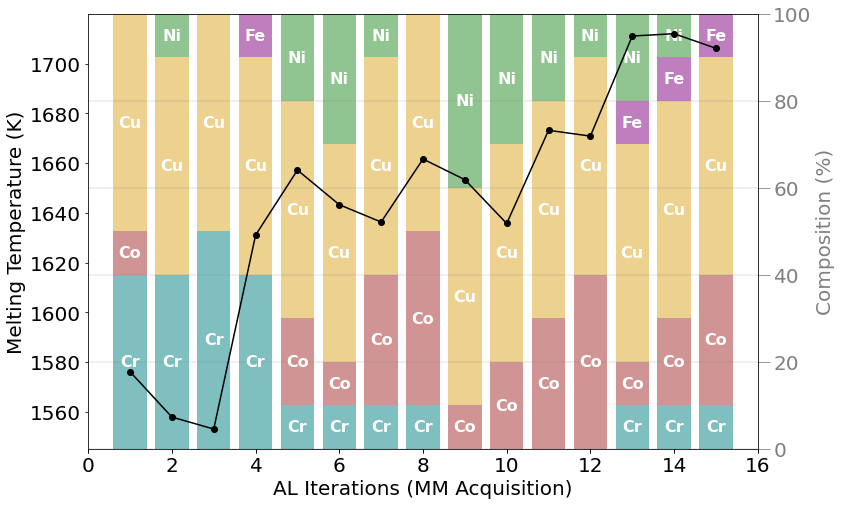

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# FORMATS
colors = ['teal', 'brown', 'goldenrod', 'purple', 'forestgreen']
plt.rcParams["font.size"] = 20

# VALUES

main_values = df.iloc[:, 6]  # 7th column for melting temperature
confidence_interval = df.iloc[:, 7]  # 8th column for confidence intervals

composition_columns = df.iloc[:, 1:6]  # Columns 2 to 6 for compositions
composition_normalized = composition_columns.div(composition_columns.sum(axis=1), axis=0)
composition_normalized = composition_columns.apply(lambda x: x * 100)

# Plot setup
fig, ax1 = plt.subplots(figsize=(12, 8))


ax1.plot(df.index + 1, main_values, marker='o', linestyle='-', color='black', zorder=10, label='MEI Acquisition Function')
ax1.set_ylabel('Melting Temperature (K)')
#ax1.legend(loc=(1.15, 0.90), fontsize=14)
ax1.set_xlabel('AL Iterations ({} Acquisition)'.format(iaf))
ax1.set_xlim([0,16])
ax1.set_facecolor('none')

ax2 = fig.add_axes(ax1.get_position(), frame_on=False, zorder=-1)  # zorder set to -1 to be behind ax1
ax2.patch.set_visible(False)  # Hide the 'ax2' patch to allow 'ax1' to be visible
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')



# Plotting each composition as a stacked bar
for i, col in enumerate(composition_normalized.columns):
    bars = ax2.bar(df.index + 1, composition_normalized.iloc[:, i],
                   bottom=composition_normalized.iloc[:, :i].sum(axis=1) if i > 0 else 0,
                   label=col, alpha=0.5, color=colors[i], zorder=1)
    # Adding text labels to each bar only if bar is visible
    for rect in bars:
        height = rect.get_height()
        if height > 0:  # Only add text if the bar is visible
            ax2.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                     col, ha='center', va='center', color='white', fontweight='bold', fontsize=16)

# Axes labels and grid configuration

ax2.set_ylabel('Composition (%)', color='gray')
ax2.tick_params(size=12, axis='y', colors='gray')
ax2.grid(True, which='major', axis='y', linestyle='-', linewidth='0.25', color='gray')
#ax2.legend(loc=(1.15, 0.10), title='Composition', fontsize=14)

ax2.set_xlim([0,16])  # Ensure x-axis limits are identical
ax2.set_xticks(ax1.get_xticks())  # Align the x-tick positions
ax2.set_xticklabels(ax1.get_xticklabels())  # Optionally match tick labels if needed



plt.show()